# TTC Arrival Time by Bohan

### Goal
This file merges responses.csv and requests.csv and outputs cleansed data for arrivial time of each train at each station.  
It is applied to all three subway lines.

It is based on Line2 data cleaning:  
https://github.com/BohanX/ttc_subway_times/blob/4c56647e1a528d4f0703d26960673bcb2b911a79/doc/arrival_time_exploration_ver2.ipynb

### Note: Each month should be processed separately because requestid is unique each month

### Things improved
1. Remove duplicates based on Request_date instead of Create_date 
2. Correct 'subwayline' and 'lineid' labeling based on nearby stations
3. Correct 'stationid' for transfer stations based on nearby stations

### Issues
1. 'traindirection' column was not corrected
2. As shown in Line 11, there are trains starts on a different line
3. As shown for trainid 27, some trains should be taken out from future analysis

#### It makes basic explation on the simple data set

In [1]:
import numpy as np;  # useful for many scientific computing in Python
import pandas as pd; # primary data structure library
import datetime; # datetime data

# data from 201907.zip were used
responses = pd.read_csv('responses_sample.csv'); # import file
requests = pd.read_csv('requests_sample.csv'); # import file

# merge two dataframes
df = pd.merge(left=responses, right=requests, left_on='requestid',
                  right_on='requestid');

#### Normalize date and time in new columns

In [2]:
# separate date and time
r_date = pd.to_datetime(df['request_date']);

df['date'] = r_date.dt.date;
df['time'] = r_date.dt.time;

#### Take data from 6am to 1:30am everyday

In [3]:
# On weekdays and Saturdays, trains run from about 6 a.m. until 1:30 a.m. 
# On Sundays, they run from about 8 a.m. to 1:30 a.m.
# Take data from 6am to 1:30am everyday

df = df[(df['time']>=datetime.time( 6,0,0 )) |
                      (df['time']<=datetime.time( 1,30,0 )) ];

#### Find arrival time and separate date and time
#### And remove duplicates based on requestid

In [4]:
# Find trains at station
df_AtStation = df[df['train_message'] == 'AtStation'];

# Find trains arriving between 0 to 2 min exclusive
df_Delayed = df[(df['train_message'] == 'Delayed') &
                              (df['timint'] <2) &
                              (df['timint'] >0)];

df_Arriving = df[(df['train_message'] == 'Arriving') &
                              (df['timint'] <2) &
                              (df['timint'] >0)]; 

#### Merge three dataframes after sorting on timint

In [5]:
# If trains are arriving or delayed in two stations, 
# keep the one takes shorter time to arrive or the first one

# sort based on Time remaining until train arrives at station (timint)
merged = pd.concat((df_AtStation.sort_values(
        by=['timint']), df_Arriving.sort_values(by=['timint'])), axis=0);
        
merged = pd.concat((merged, df_Delayed.sort_values(
        by=['timint'])), axis=0);
l1 = len(merged); # store length for comparison

#### Remove duplicates based on request_date (i.e. a train should not be at two different stations at the same time)
  
1. Sort based on Time remaining until train arrives at station (timint) and train_message in the order to keep the ones first appear on the top (done in previous section)
2. Remove duplicates from the bottom

#### Check for duplicates by trainid and request_date

In [6]:
m_du = merged[merged.duplicated(subset=['trainid','request_date'], keep=False)];
m_du.sort_values(by=['request_date','trainid'], inplace=True);
m_du

C:\Users\erwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,requestid,id,station_char,subwayline,system_message_type,timint,traindirection,trainid,train_message,train_dest,data_,stationid,lineid,all_stations,create_date,pollid,request_date,date,time
409466,80941,31832060304,VMC2,YUS,Normal,0.911315,South,101,Arriving,Southbound<br/> To Union,NaN,80,1,success,2019-07-07 07:40:33,1172,2019-07-07 07:40:41.912693-04:00,2019-07-07,07:40:41.912693
409464,80941,31832060306,VMC1,YUS,Normal,0.911315,South,101,Arriving,Southbound<br/> To Union,NaN,80,1,success,2019-07-07 07:40:33,1172,2019-07-07 07:40:41.912693-04:00,2019-07-07,07:40:41.912693
409400,80883,31832060362,VMC2,YUS,Normal,0.911315,South,101,Arriving,Southbound<br/> To Union,NaN,80,1,success,2019-07-07 07:40:42,1170,2019-07-07 07:40:47.469805-04:00,2019-07-07,07:40:47.469805
409398,80883,31832060364,VMC1,YUS,Normal,0.911315,South,101,Arriving,Southbound<br/> To Union,NaN,80,1,success,2019-07-07 07:40:42,1170,2019-07-07 07:40:47.469805-04:00,2019-07-07,07:40:47.469805
409433,80912,31832060362,VMC2,YUS,Normal,0.911315,South,101,Arriving,Southbound<br/> To Union,NaN,80,1,success,2019-07-07 07:40:42,1171,2019-07-07 07:40:48.594767-04:00,2019-07-07,07:40:48.594767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431042,87277,32039547211,KIP1,BD,Normal,0.493329,East,218,Arriving,Eastbound</br> To Kennedy,NaN,33,2,success,2019-07-15 01:29:11,1264,2019-07-15 01:29:13.276414-04:00,2019-07-15,01:29:13.276414
430692,87197,32039562601,STC1,YUS,Normal,1.153160,North,813,Arriving,Northbound<br/> To Finch,NaN,25,1,success,2019-07-15 01:29:51,1263,2019-07-15 01:29:53.202220-04:00,2019-07-15,01:29:53.202220
430694,87197,32039562612,STC2,YUS,Normal,1.153160,North,813,Arriving,Northbound<br/> To Finch,NaN,25,1,success,2019-07-15 01:29:51,1263,2019-07-15 01:29:53.202220-04:00,2019-07-15,01:29:53.202220
430693,87197,32039562602,STC1,YUS,Normal,1.784209,South,831,AtStation,Southbound<br/> To Union,NaN,25,1,success,2019-07-15 01:29:51,1263,2019-07-15 01:29:53.202220-04:00,2019-07-15,01:29:53.202220


In [7]:
## Now it should be in the order AtStation / timint(ascending) -> Arriving / timint(ascending) -> Delayed / timint(ascending)
# remove duplicates
merged.drop_duplicates(subset=['trainid','request_date'],keep='first',inplace=True);

print('Number of duplicates = ', l1-len(merged));

Number of duplicates =  10770


#### Check for duplicates by trainid and create_date (should be empty)

In [8]:
merged[merged.duplicated(subset=['trainid','request_date'], keep=False)]

,requestid,id,station_char,subwayline,system_message_type,timint,traindirection,trainid,train_message,train_dest,data_,stationid,lineid,all_stations,create_date,pollid,request_date,date,time


#### Check and Remove unnecessary columns

In [9]:
# check system_message_type to be Normal
a = sorted(merged['system_message_type']);
if a[0] == a[-1]:
    merged.drop(['system_message_type'],axis=1, inplace=True);
else:
    print('system_message_type coloumn is not all Normal');

# check data_ to be nan
if np.isnan(np.min(merged['data_'])):
    merged.drop(['data_'],axis=1, inplace=True);
else:
    print('data_ coloumn is not all nan');
    
# check all_stations to be success
a = sorted(merged['all_stations']);
if a[0] == a[-1]:
    merged.drop(['all_stations'],axis=1, inplace=True);
else:
    print('all_stations coloumn is not all success');
    
# remove directionality in station_char
merged['station_char'] = merged['station_char'].str[:-1];

### Same trainid can be used on separate days
### So, correction should be sepcific to that day

In [10]:
# check if each trainid appears only once
for i in merged['trainid'].unique():
    d = merged[merged['trainid'] == i]['date'];
    d = d.sort_values()
    if d.iloc[0] != d.iloc[-1]:
        print(i)
        print(d.iloc[0], d.iloc[-1])

109
2019-07-07 2019-07-14
110
2019-07-07 2019-07-15
114
2019-07-07 2019-07-15
111
2019-07-07 2019-07-14
30
2019-07-07 2019-07-15
27
2019-07-07 2019-07-15
461
2019-07-07 2019-07-15
28
2019-07-07 2019-07-15
115
2019-07-07 2019-07-15
209
2019-07-07 2019-07-15
213
2019-07-07 2019-07-15
107
2019-07-07 2019-07-15
215
2019-07-07 2019-07-15
201
2019-07-07 2019-07-15
219
2019-07-07 2019-07-15
220
2019-07-07 2019-07-15
462
2019-07-07 2019-07-15
210
2019-07-07 2019-07-15
108
2019-07-07 2019-07-15
214
2019-07-07 2019-07-15
118
2019-07-07 2019-07-14
120
2019-07-14 2019-07-15
116
2019-07-07 2019-07-15
207
2019-07-07 2019-07-15
211
2019-07-07 2019-07-15
204
2019-07-07 2019-07-15
216
2019-07-07 2019-07-15
218
2019-07-07 2019-07-15
221
2019-07-07 2019-07-15
29
2019-07-07 2019-07-15
464
2019-07-07 2019-07-15
463
2019-07-07 2019-07-15
103
2019-07-07 2019-07-14
101
2019-07-07 2019-07-14
126
2019-07-07 2019-07-15
106
2019-07-07 2019-07-15
203
2019-07-07 2019-07-15
133
2019-07-07 2019-07-14
132
2019-07-07 2

### Some trains starts from one terminal but operates on a different line 
### Example shows a train starts at KIP but operates on Line 1
### So, I will use stations in the middle to correct 'subwayline' and 'lineid'

In [11]:
print(merged[merged['trainid']==109].station_char.unique());
merged[merged['trainid']==109].sort_values(by=['request_date'])

['QUN' 'KNG' 'DUN' 'STA' 'SUM' 'STC' 'BLO' 'WEL' 'ROS' 'SCW' 'DUP' 'CVL'
 'QPK' 'STP' 'SPA' 'SGU' 'MUS' 'UNI' 'COL' 'LWW' 'WIL' 'SHW' 'YKD' 'FIW'
 'DNP' 'YUN' 'GCN' 'PVL' 'VMC' 'HWY' 'OSG' 'KIP']


,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,stationid,lineid,create_date,pollid,request_date,date,time
407257,79754,31832085666,KIP,BD,0.000000,East,109,AtStation,Eastbound</br> To Kennedy,33,2,2019-07-07 08:02:08,1139,2019-07-07 08:02:18.270249-04:00,2019-07-07,08:02:18.270249
407114,79693,31832091235,KIP,BD,0.000000,East,109,AtStation,Eastbound</br> To Kennedy,33,2,2019-07-07 08:03:15,1138,2019-07-07 08:03:19.760852-04:00,2019-07-07,08:03:19.760852
406932,79630,31832095317,KIP,BD,0.000000,East,109,AtStation,Eastbound</br> To Kennedy,33,2,2019-07-07 08:04:08,1137,2019-07-07 08:04:18.414566-04:00,2019-07-07,08:04:18.414566
406743,79566,31832103225,KIP,BD,0.000000,East,109,AtStation,Eastbound</br> To Kennedy,33,2,2019-07-07 08:05:24,1136,2019-07-07 08:05:25.886409-04:00,2019-07-07,08:05:25.886409
406550,79501,31832107872,KIP,BD,0.000000,East,109,AtStation,Eastbound</br> To Kennedy,33,2,2019-07-07 08:06:18,1135,2019-07-07 08:06:25.653992-04:00,2019-07-07,08:06:25.653992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475618,97008,32036474535,SHW,YUS,1.426574,North,109,Arriving,Northbound<br/> To Finch,1,1,2019-07-14 23:04:46,1408,2019-07-14 23:04:46.839682-04:00,2019-07-14,23:04:46.839682
475311,96940,32036495815,SHW,YUS,0.000000,North,109,AtStation,Northbound<br/> To Finch,1,1,2019-07-14 23:05:46,1407,2019-07-14 23:05:47.064311-04:00,2019-07-14,23:05:47.064311
474658,96805,32036539928,WIL,YUS,1.501259,North,109,Arriving,Northbound<br/> To Finch,2,1,2019-07-14 23:07:46,1405,2019-07-14 23:07:47.260145-04:00,2019-07-14,23:07:47.260145
474338,96737,32036561631,WIL,YUS,0.000000,North,109,AtStation,Northbound<br/> To Finch,2,1,2019-07-14 23:08:46,1404,2019-07-14 23:08:47.226374-04:00,2019-07-14,23:08:47.226374


### Following section will find mislabeled trains and correct them

In [12]:
# sort by trainid, request_date
merged.sort_values(by=['trainid', 'request_date'], inplace=True);
# reset index
merged.reset_index(drop=True,inplace=True);
# find incorrect assignments of subwayline and lineid
AE = ((merged['subwayline'] == 'YUS' ) != (merged['lineid'] == 1)) | ( 
    (merged['subwayline'] == 'BD' ) != (merged['lineid'] == 2)) | (
    (merged['subwayline'] == 'SHEP' ) != (merged['lineid'] == 4));


In [13]:
# create a list of trainid and date
id_error =  merged['trainid'].loc[AE==True].unique();
L = merged.loc[AE==True];
# initiate some variables for debugging purposes
line1_trains = 0;
line2_trains = 0;
line4_trains = 0;
Sort_error = pd.Index([],dtype='int64');

# run loop for each unique trainid, then unique date with this trainid
# then test nearby stations for each line separately
# then correct subwayline & lineid, switch station id 

for i in id_error:
    for j in L[L['trainid']==i]['date'].unique():
            # check if the train stops at Dupont (DUP), Museum(MUS), 
            # York Mills(YKM), North York Centre(NYC), Rosedale (ROS) Wellesley (WEL)
            # if yes, then it is on line 1
        if merged[(merged['trainid']==i) & (merged['date']==j)]['station_char'].str.contains(
            'DUP|MUS|YKM|NYK|ROS|WEL').any():

                # check if the train also stops on line 2 and 4
            if merged[(merged['trainid']==i) & (merged['date']==j)]['station_char'].str.contains(
                'BSS|BAU|BAT|SHE').any():
                print('error in if line 1 section')
                print('error in train', i)
                Sort_error = Sort_error.append( merged[(merged['trainid']==i) & (merged['date']==j)].index);
            # make correction
            merged.loc[(merged['trainid']==i) & (merged['date']==j), 'subwayline'] = 'YUS';
            merged.loc[(merged['trainid']==i) & (merged['date']==j), 'lineid'] = 1;
            
            # add counter
            line1_trains = line1_trains +1;
            
        # check if the train stops at Bay station (BAU), Bathurst (BAT), Sherbourne (SHE)
        # if yes, then it is on line 2
        elif merged[(merged['trainid']==i) & (merged['date']==j)]['station_char'].str.contains('BAU|BAT|SHE').any():
                # check if the train also stops on line 4 because we already checked for line 1 
            if merged[(merged['trainid']==i) & (merged['date']==j)]['station_char'].str.contains(
                'BSS').any():
                print('error in elif line 2 section')
                print('error in train', i)
                Sort_error = Sort_error.append( merged[(merged['trainid']==i) & (merged['date']==j)].index);
            
            # make correction
            merged.loc[(merged['trainid']==i) & (merged['date']==j), 'subwayline'] = 'BD';
            merged.loc[(merged['trainid']==i) & (merged['date']==j), 'lineid'] = 2;
            
            # add counter
            line2_trains = line2_trains +1;

            # check if the train stops at Bessarion (BSS)
            # if yes, then it is on line 4
            # NO NEED to make additional checks
        elif merged[(merged['trainid']==i) & (merged['date']==j)]['station_char'].str.contains('BSS').any():
            
            # make correction
            merged.loc[(merged['trainid']==i) & (merged['date']==j), 'subwayline'] = 'SHEP';
            merged.loc[(merged['trainid']==i) & (merged['date']==j), 'lineid'] = 4;
                        
             # add counter
            line4_trains = line4_trains +1;

        # if no, sorting error
        else:
            print('error in else section')
            print('error in train', i)
            Sort_error = Sort_error.append( merged[(merged['trainid']==i) & (merged['date']==j)].index);

print('# of relabeled line 1 trains: ', line1_trains)
print('# of relabeled line 2 trains: ', line2_trains)
print('# of relabeled line 4 trains: ', line4_trains)            

error in else section
error in train 27
# of relabeled line 1 trains:  160
# of relabeled line 2 trains:  84
# of relabeled line 4 trains:  19


#### Train 27 was not opperating on July 7 because it only stopped at SHP station

In [14]:
merged[merged['trainid']==27]

,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,stationid,lineid,create_date,pollid,request_date,date,time
2360,14582,31852166233,SHP,YUS,1.130018,North,27,Arriving,Northbound<br/> To Finch,30,1,2019-07-07 23:24:10,217,2019-07-07 23:24:11.132869-04:00,2019-07-07,23:24:11.132869
2361,14622,31852172574,SHP,YUS,0.768773,North,27,Arriving,Northbound<br/> To Finch,64,4,2019-07-07 23:24:27,217,2019-07-07 23:24:28.346411-04:00,2019-07-07,23:24:28.346411
2362,126597,32026890246,LAW,YUS,0.767644,South,27,Arriving,Southbound<br/> To Union,28,1,2019-07-14 15:49:08,1844,2019-07-14 15:49:09.783375-04:00,2019-07-14,15:49:09.783375
2363,126529,32026914739,LAW,YUS,0.000000,South,27,AtStation,Southbound<br/> To Union,28,1,2019-07-14 15:50:09,1843,2019-07-14 15:50:10.258181-04:00,2019-07-14,15:50:10.258181
2364,126326,32026980968,LAW,YUS,0.000000,North,27,AtStation,Southbound<br/> To Union,28,1,2019-07-14 15:53:11,1840,2019-07-14 15:53:11.632730-04:00,2019-07-14,15:53:11.632730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2902,87540,32039456194,SHP,YUS,0.000000,North,27,AtStation,Northbound<br/> To Finch,30,1,2019-07-15 01:25:06,1268,2019-07-15 01:25:07.913573-04:00,2019-07-15,01:25:07.913573
2903,87541,32039456195,NYC,YUS,1.223218,North,27,Arriving,Southbound<br/> To Union,31,1,2019-07-15 01:25:06,1268,2019-07-15 01:25:08.200168-04:00,2019-07-15,01:25:08.200168
2904,87473,32039478879,NYC,YUS,0.516467,North,27,Arriving,Southbound<br/> To Union,31,1,2019-07-15 01:26:08,1267,2019-07-15 01:26:09.369585-04:00,2019-07-15,01:26:09.369585
2905,87338,32039525363,FIN,YUS,0.909884,North,27,Arriving,Southbound<br/> To Union,32,1,2019-07-15 01:28:10,1265,2019-07-15 01:28:10.754993-04:00,2019-07-15,01:28:10.754993


### We can remove these two rows:

In [15]:
# OPTION to drop Sort_error
if len(Sort_error) != 0:
    merged.drop(Sort_error, inplace=True);

### Correct mislabeled stationid 

In [16]:
# find and correct mislabeled stationid
# line 1
merged.loc[(merged['lineid']==1) & (merged['stationid'] == 47), 'stationid'] = 9;
merged.loc[(merged['lineid']==1) & (merged['date']==j) & (merged['stationid'] == 48), 'stationid'] = 10;
merged.loc[(merged['lineid']==1) & (merged['date']==j) & (merged['stationid'] == 50), 'stationid'] = 22;

# line 2
merged.loc[(merged['lineid']==2) & (merged['stationid'] == 9), 'stationid'] = 47;
merged.loc[(merged['lineid']==2) & (merged['stationid'] == 10), 'stationid'] = 48;
merged.loc[(merged['lineid']==2) & (merged['stationid'] == 22), 'stationid'] = 50;

# line 4
merged.loc[(merged['lineid']==4) & (merged['stationid'] == 30), 'stationid'] = 64;

# sort by 'date','trainid','time'
merged.sort_values(by=['lineid','date','trainid','time'], inplace=True);

# reset index
merged.reset_index(drop=True,inplace=True);

### Plot behaviour of one train

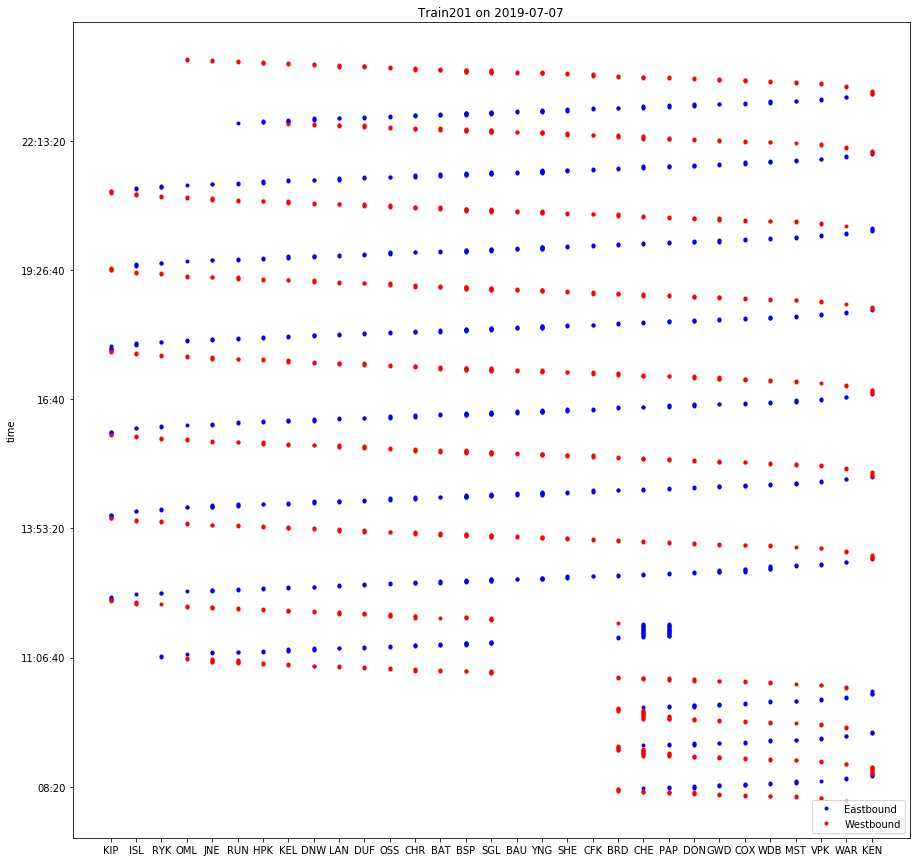

In [18]:
# plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
train = 201;
day = datetime.date(2019,7,7);
plt.plot(merged[(merged['trainid'] == train) & (merged['traindirection'] == 'East') &
                (merged['date'] == day)]['stationid'],
        merged[(merged['trainid'] == train) & (merged['traindirection'] == 'East') &
                (merged['date'] == day)]['time'],'b.', label='Eastbound')

plt.plot(merged[(merged['trainid'] == train) & (merged['traindirection'] == 'West') &
                (merged['date'] == day)]['stationid'],
        merged[(merged['trainid'] == train) & (merged['traindirection'] == 'West') &
                (merged['date'] == day)]['time'],'r.', label='Westbound')
plt.xticks(merged[merged['trainid']==train]['stationid'].unique(), 
           merged[merged['trainid']==train]['station_char'].unique())
plt.title('Train'+str(train)+' on '+str(day))
plt.legend(loc='lower right')
plt.show()